<a href="https://colab.research.google.com/github/drewwint/Quant-Family-Collective-fMRI-stats/blob/main/DWinters_QFC_wb2_fMRI_task_second_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task-Based fMRI: Intuition for group-level analysis and contrasts
### Drew E. Winters, PhD.
- Lesson adapted from code provided by Dr. Luke Chang

This tutorial aims to provide an intuative sense for inferential statistics using the estimated first-level BOLD activations to estimate patterns across participants. Here we will want to consider what we want to know about brain patterns in the task conditions we have. This will lead us to how we collect and model our data.

This will involve outlining different ways to contrast between conditions and between participants.

We will simulate multiple participants for this tutorial and will continue to only focus on one voxel to demonstrate the concepts. This will serve as the basis for later tutorials were we conduct analyses across the entire brain.

Lets start with loading our packages

In [1]:
# Installing package nltools
! pip install nltools &> /dev/null

from scipy import stats
import seaborn as sns
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nltools.stats import regress, zscore
from nltools.external import glover_hrf
from scipy.stats import ttest_1samp

## First Level - Single Subject Model

In fMRI data analysis, we often break analyses into multiple stages. First, we are interested in estimating the parameter (or distribution) of signal in a given region resulting from our experimental manipulation, while simultaneously attempting to control for as much noise and artifacts as possible. This will give us a a single number for each participant - here we will have a single estimate for faces and one for object for each participant.

To review: the first-level model for each participant is defined as:

$Y_i = X_i + \beta + \epsilon_i$, where is an observation for a single participant and $\epsilon$ ~ Ŋ$(0,\sigma_i^2)$

- $\epsilon$ = error
- Ŋ = normal distribution characterized by parameters $(0,\sigma_i^2)$
- 0 = mean of 0
- $\sigma_i^2$ = variance

We can estimate each participant separately because they are independent.

First, lets create a function to simulate data to make simulating multiple participants easier.

In [60]:
# @title functions for simulating and plotting timeseries
# n_tr = 200
# n_trial = 5

def sim_fo_ts(n_tr=200, n_trial=5, amplitude=1, tr=2, sigma=0.05):
    face = np.zeros(n_tr)
    face[np.arange(10, n_tr, int(n_tr/n_trial))] = (amplitude)
    face2 = np.zeros(n_tr)
    face2[np.arange(10, n_tr, int(n_tr/n_trial))] = (amplitude + (amplitude/2))
    obj = np.zeros(n_tr)
    obj[np.arange(20, n_tr, int(n_tr/n_trial))] = (amplitude)
    signal = np.vstack([face, obj]).T

    hrf = glover_hrf(tr, oversampling=1)

    face_conv = np.convolve(face, hrf, mode='same')
    face_conv2 = np.convolve(face2, hrf, mode='same')
    obj_conv = np.convolve(obj, hrf, mode='same')
    conv_ts_f = np.vstack([face_conv, obj_conv]).T
    conv_ts_r = np.vstack([face_conv2, obj_conv]).T
    ts_f = conv_ts_f.sum(axis=1)
    ts_r = conv_ts_r.sum(axis=1)

    epsilon = sigma*np.random.randn(n_tr)
    y_noise = ts_r + epsilon
    return signal, face_conv, obj_conv, conv_ts_f, ts_f, y_noise

def plot_timeseries(data, linewidth=3, labels=None, axes=True):
    f,a = plt.subplots(figsize=(20,5))
    a.plot(data, linewidth=linewidth)
    a.set_ylabel('Intensity', fontsize=18)
    a.set_xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        plt.legend(labels, fontsize=18)
    if not axes:
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)

Now we will estimate 5 participants.

Make sure to extract the expected HRF model to estimate at the first-level values.

Note that we are varying the error and emplitude by participant.

In [61]:
sim_sig, face, obj, sim_cov_ts, sim_ts, _ = sim_fo_ts(sigma=0)

np.random.seed(123)
sim1 = sim_fo_ts(amplitude=np.abs(np.random.randn())*2, sigma=0.05)[5]
sim2 = sim_fo_ts(amplitude=np.abs(np.random.randn())*3, sigma=0.10)[5]
sim3 = sim_fo_ts(amplitude=np.abs(np.random.randn())*2, sigma=0.15)[5]
sim4 = sim_fo_ts(amplitude=np.abs(np.random.randn())*3, sigma=0.20)[5]
sim5 = sim_fo_ts(amplitude=np.abs(np.random.randn()), sigma=0.15)[5]

Here is the expected model.

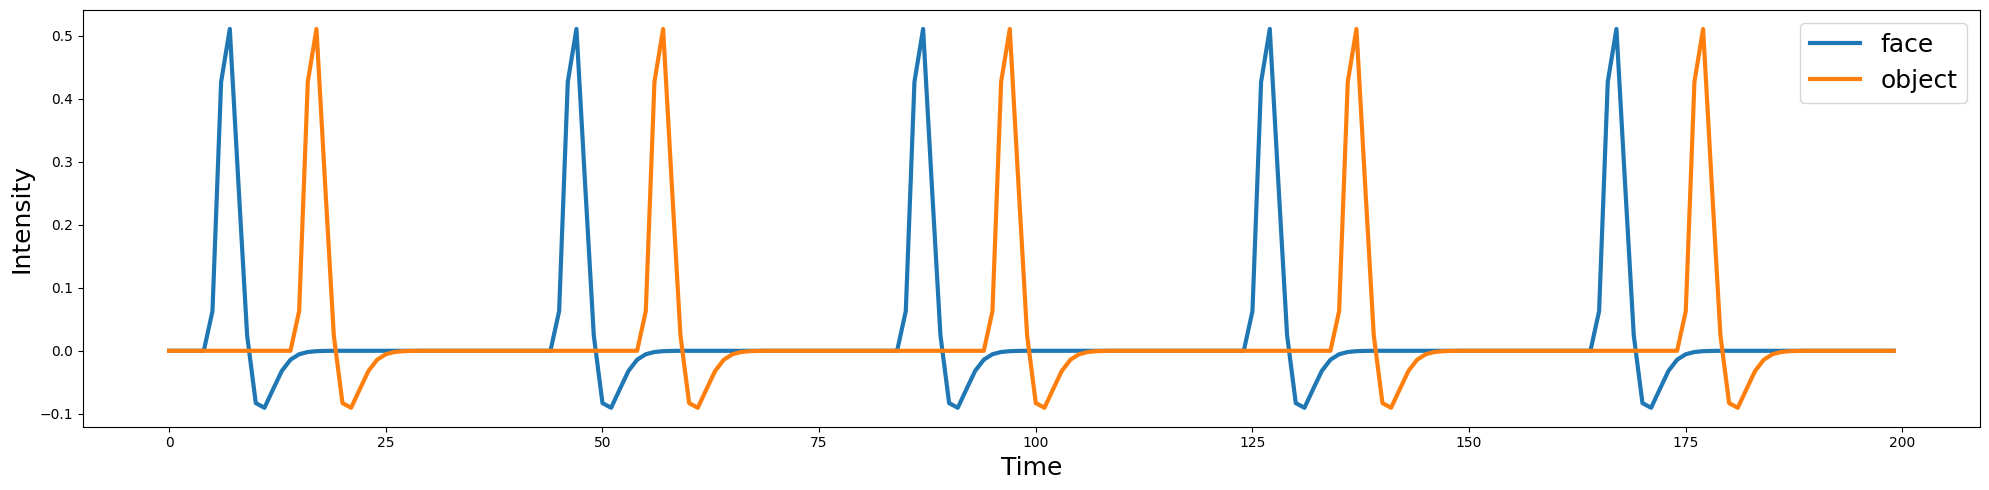

In [62]:
plot_timeseries(sim_cov_ts, labels = ["face","object"])

Here are all 5 subjects plotted together.

We can see similarities along with some deviation specific to each subject.

This is because the second level model focuses on relating the subject specific parameters to the population parameters. We assume that the first-level parameters are randomly sampled from a population of possible regression parameters.

$\beta = X_g\beta_g+ŋ$

ŋ ~ Ŋ$(0, \sigma_g^2)$

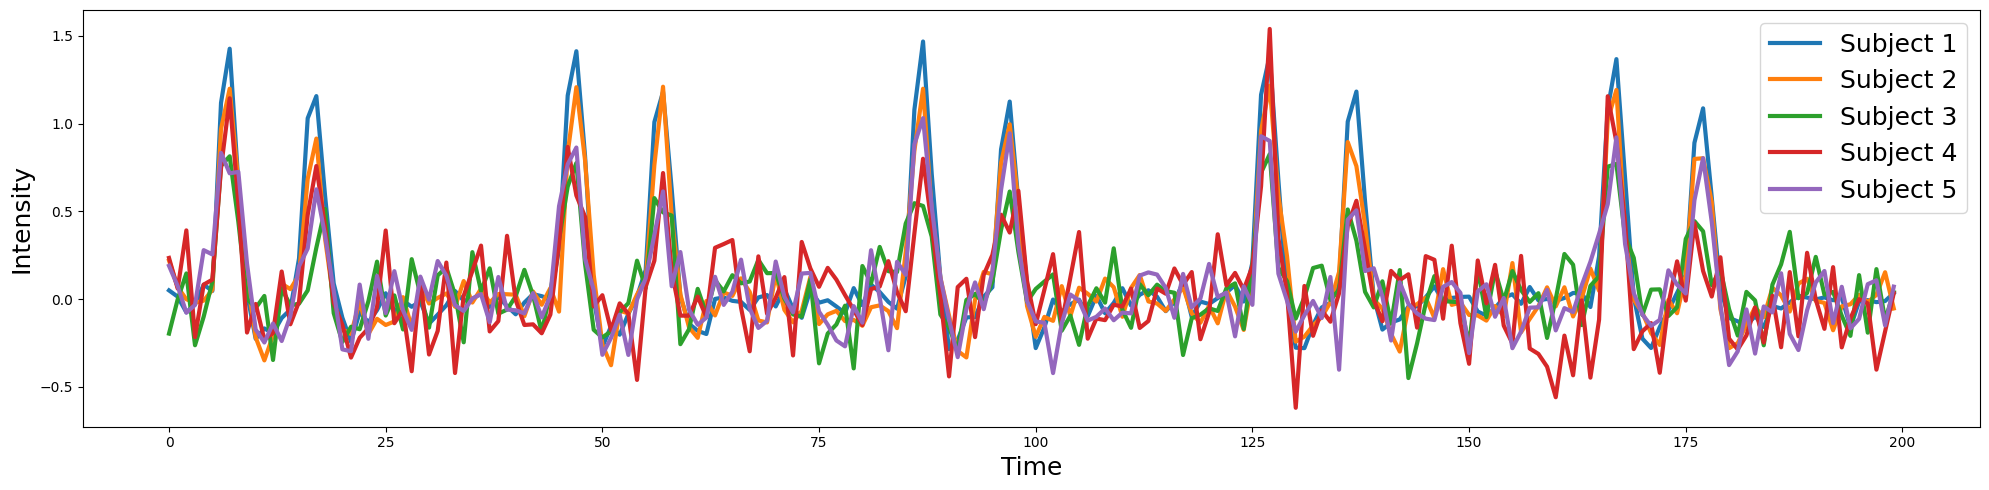

In [63]:
plot_timeseries(np.vstack([sim1,
                           sim2,
                           sim3,
                           sim4,
                           sim5]).T,
                labels=['Subject 1',
                        'Subject 2',
                        'Subject 3',
                        'Subject 4',
                        'Subject 5'])

We may want to test if there are differneces between conditions for all participants, or we may want to test differences within or between groups.

In order to make inferences on reliable differences we model the parameters form the individual-level model usign a group-level model. In our example, we are interested in activation during the face condition relative to the object condition. Is the activation when viewing faces larger than viewing objects?

This first question can be modeled within-individual and compared across all participants. We may have a situation where we have groups we want to compare too.


### Note:

We cover the two-stage approch with separate individual-level then group-level analyses for conceptual ease and this is ithe standard in popular packages such as SPM.

There is another approach - random effects - that simultaneously estimates the individual and group levels at the same time ausing algorithms that iterate back and forth from the single to the group.
- The advantage of this is that the uncertainty in the parameter estimates at the individual-level can be appropriately weighted at the group level. For example, if we had a bad participant with very noisy data, we might not want to weight their estimate when we aggregate everyone’s data across the group.
- The disadvantage of this approach is that the estimation procedure is considerably more computationally expensive. This is the approach implemented in FSL, BrainVoyager, and AFNI.

In practice, the advantage of simultaneous parameter estimation only benefits reliability when the sample size is small and both methods should converge to the same answer.  

A full mixed effects model can be written as,

$Y_i = X_i(X_g\beta_g+\eta) + \epsilon_i$

### OR

$Y$ ~ $(XX+g\beta_g,X\sigma^2_gX^T+\sigma^2)$

There are also many other approaches for the individulal-level that we are not covering such as volumetric versus surface based approaches, or different estimates such as maximum liklihood or bayesian approaches [see article by Amanda Mejia and collegues](https://doi.org/10.1080/01621459.2019.1611582). However, we aim to build an inutative sense that can be built on in more detail later if there is interest.

Let’s now try to recover the beta estimates simulated subjects.

We will start by setting up our first-level analysis by specifying the expected model $X$ and then running GLM.

We will look at the betas and the mean squared error of the residual to evaluate performance (values closer to 0 indicates better performance)

In [64]:
intercept = np.ones(n_tr)
X = np.vstack([intercept, face, obj]).T

In [65]:
import statsmodels.api as sm

betas = []
mse_res = []
for i in [sim1,sim2,sim3,sim4,sim5]:
  betas.append(sm.OLS(i, X).fit().params)
  mse_res.append(sm.OLS(i, X).fit().mse_resid)


In [66]:
betas

[array([-2.09499705e-03,  2.71189234e+00,  2.23989287e+00]),
 array([-0.01313005,  2.30548082,  1.86888578]),
 array([0.01422386, 1.43802925, 0.86848483]),
 array([-0.01611777,  1.87453333,  1.04046996]),
 array([-0.01204117,  1.79507949,  1.27454182])]

In [67]:
mse_res

[0.0027229554982281384,
 0.008730482307583852,
 0.02330479376030815,
 0.042696783357506665,
 0.02068895256433111]

# second level

We will start by extracting the relevant BOLD estimates for each condition and each participant and placing them in a list so we can run contrasts for statistical compairions.

In [68]:
face_b = []
obj_b = []
#int_b = []
for i in betas:
#  int_b.append(i[0])
  face_b.append(i[1])
  obj_b.append(i[2])


We will stack our betas so that we have faces then object betas for each individual.

In [69]:
sub_fo = []
for i in betas:
  sub_fo.append(i[1])
  sub_fo.append(i[2])

lets make sure this behaved as expected

In [70]:
sub_fo

[2.7118923404351865,
 2.239892873694939,
 2.3054808233998205,
 1.8688857775128627,
 1.438029245613664,
 0.8684848294339156,
 1.8745333254885717,
 1.0404699585502204,
 1.795079490403991,
 1.2745418188545128]

#Contrasts
Contrasts describe a linear combination of variables in a regression model whose coefficients add up to zero. This allows us to flexibly compare different experimental conditions.

For example, suppose we just wanted to know the magnitude of an effect for a single condition, such as the brain response to faces. We would create a contrast code that isolates the effect size (i.e., estimate for the face regressor)

If our GLM, was:

$Y = \beta_0 * Intercept + \beta_1 * Faces + \beta_2 * Objects$

then, the corresponding contrast code or vector for faces would be:

[0, 1, 0]

The contrast code for the object condition would be:

[0, 0, 1]

and importantly the contrast between the face and object condition would be:

[0, 1, -1]

More simply, we are calculating the magnitude of the effect of the difference between viewing faces and objects in a single voxel.

To make this a little bit more clear, we will show a graphical representation of the design matrix to make it obvious what we are contrasting.

<Axes: >

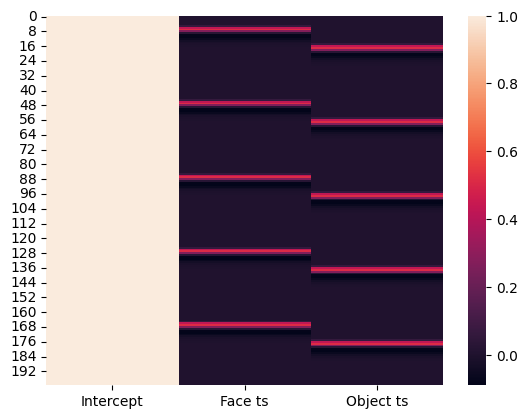

In [73]:
X = pd.DataFrame(X)
X.columns = ["Intercept","Face ts","Object ts"]

sns.heatmap(X)

### Function for contrast and analyses

Here we will create a function called "run_regression_simulation" that will allow us to disply our design matrix and produce the statistics for inferences.

I have hidden this function for sake of space - if you want to look at the function you can open it below.

We will use regression to conduct a series of t-test contrasts.

In [36]:
#@title Function: run_regression_simulation
def run_regression_simulation(x, y, paired=False, gint = False, gint_c = False):
    '''This Function runs a regression and outputs results'''
    if not paired and gint == False and gint_c == False:
        b, t, dunno, p, df, res = regress(x, y)
        print(f"betas: {b}")
        if x.shape[1] > 1:
          aa = y[x.iloc[:,1]==1]
          bb = y[x.iloc[:,1]==np.min(x.iloc[:,1])]
          print("2nd-level")
          print("   ","Intercept:")
          print("   ","   ", f"beta0:  {b[0]}")
          print("   ","   ", f"sig   {p[0]}")
          print("   ","Estimate:")
          print("   ","   ", f"beta1:  {b[1]}")
          print("   ","   ", f"sig:   {p[1]}")
          print("   ", f"beta0 + beta1: {b[0] + b[1]}")
          print("   ", f"beta0 - beta1: {b[0] - b[1]}")
          print("1st level")
          print("   ", f"mean(group1): {np.mean(aa)}")
          print("   ", f"mean(group2): {np.mean(bb)}")
          print("   ", f"mean(group1) - mean(group2): {np.mean(aa)-np.mean(bb)}")
        print("   ", f"mean(y): {np.mean(y)}")
    elif not paired and gint == True:
        b, t, dunno, p, df, res = regress(x, y)
        print(f"betas: {b}")
        if x.shape[1] > 1:
          aa = y[x.iloc[:,1]==1]
          bb = y[x.iloc[:,1]==np.min(x.iloc[:,1])]
          print("2nd-level")
          print("   ","Group 2:")
          print("   ","   ", f"beta0:  {b[0]}")
          print("   ","   ", f"sig   {p[0]}")
          print("   ","Group 1:")
          print("   ","   ", f"beta1:  {b[1]}")
          print("   ","   ", f"sig:   {p[1]}")
          print("   ", f"beta0 + beta1: {b[0] + b[1]}")
          print("   ", f"beta0 - beta1: {b[0] - b[1]}")
          print("1st level")
          print("   ", f"mean(group1): {np.mean(aa)}")
          print("   ", f"mean(group2): {np.mean(bb)}")
          print("   ", f"mean(group1) - mean(group2): {np.mean(aa)-np.mean(bb)}")
        print("   ", f"mean(y): {np.mean(y)}")
    elif not paired and gint_c == True:
        b, t, dunno, p, df, res = regress(x, y)
        print(f"betas: {b}")
        if x.shape[1] > 1:
          aa = y[x.iloc[:,0]==1][(np.where([x.iloc[:,1]==1])[1]) - np.min(np.where([x.iloc[:,1]==1])[1])]
          bb = y[x.iloc[:,0]==np.min(x.iloc[:,0])][(np.where([x.iloc[:,2]==1])[1]) - np.min(np.where([x.iloc[:,2]==1])[1])]
          print("2nd-level")
          print("   ","Contrast beta:")
          print("   ","   ", f"beta0:  {b[0]}")
          print("   ","     ", f"sig   {p[0]}")
          print("   ","Mean Group 1:")
          print("   ","   ", f"beta1:  {b[1]}")
          print("   ","    ", f"sig:   {p[1]}")
          print("   ","Mean Group 2:")
          print("   ","   ", f"beta2:  {b[2]}")
          print("   ","    ", f"sig:   {p[2]}")
          print("   ", f"beta0 + beta1: {b[0] + b[1]}")
          print("   ", f"abs(beta0 - beta2): {abs(b[0] - b[2])}")
          print("   ", f"beta0 + mean(y): {b[0] + np.mean(y)}")
          print("   ", f"abs(beta0 - mean(y)): {abs(b[0] - np.mean(y))}")
          print("   ", f"beta1 + beta2: {b[1] + b[2]}")
          print("1st level")
          print("   ", f"mean(group1): {np.mean(aa)}")
          print("   ", f"mean(group2): {np.mean(bb)}")
          print("   ", f"mean(group1) + mean(group2): {np.mean(aa)+np.mean(bb)}")
          print("   ", f"mean(group1) - mean(group2): {np.mean(aa)-np.mean(bb)}")
          print("   ", f"mean(group1) - mean(group2) / 2: {(np.mean(aa)-np.mean(bb))/2}")
        print("   ", f"mean(y): {np.mean(y)}")
    elif paired==True:
        beta, t, dunno, p, df, res = regress(x, y)
        a = y[x.iloc[:,0]==1]
        b = y[x.iloc[:,0]==-1]
        out = []
        for sub in range(1, x.shape[1]):
            sub_dat = y[x.iloc[:, sub]==1]
            out.append(sub_dat-np.mean(sub_dat))
        avg_sub_mean_diff = np.mean([x[0] for x in out])
        print("Betas")
        print("   ",f"Beta0: {beta[0]}")
        print("   ",f"Beta1: {beta[1]}")
        print("   ",f"Beta2: {beta[2]}")
        print("   ",f"Beta3: {beta[3]}")
        print("   ",f"Beta4: {beta[4]}")
        print("   ",f"Beta5: {beta[5]}")
        print("2nd level:")
        print("   ",f"Contrast beta: {beta[0]}")
        print("   ","Contrast p:","  ", p[0])
        print("   ",f"Subject betas Mean: {np.mean(beta[1:])}")
        print("1st Level:")
        print("   ",f"y (voxel betas) Mean: {np.mean(y)}")
        print("   ",f"Face voxel betas Mean: {a.mean()}")
        print("   ",f"Object voxel betas Mean: {b.mean()}")
        print("   ",f"face - object Mean: {np.mean(a - b)}")
        print("   ",f"Average subject mean difference: {avg_sub_mean_diff}")
        print("   ")

    # Create Plot
    if not paired:
      from matplotlib.colors import ListedColormap
      cmap = sns.cubehelix_palette(reverse=True,n_colors=3)
      f,a = plt.subplots(ncols=2, sharey=True)
      sns.heatmap(pd.DataFrame(y),
                  ax=a[0],
                  cbar=True,
                  yticklabels=False,
                  xticklabels=False,
                  cbar_kws = dict(use_gridspec=True,location="left"))
      sns.heatmap(x,
                  ax=a[1],
                  cbar=True,
                  yticklabels=False,
                  cmap = ListedColormap(cmap))
      a[1].collections[0].set_clim(-1,1)
      colorbar = a[1].collections[0].colorbar
      colorbar.set_ticks([1,0,-1])
      a[0].set_ylabel('Subject Values', fontsize=13)
      a[0].set_title('Y')
      a[1].set_ylabel('Design Matrix', fontsize=13)
      a[1].set_title('X')
      plt.tight_layout()
    elif paired==True:
      from matplotlib.colors import ListedColormap
      cmap = sns.cubehelix_palette(rot=.5,reverse=True,n_colors=3)
      f,a = plt.subplots(ncols=2, sharey=True)
      sns.heatmap(pd.DataFrame(y),
                  ax=a[0],
                  cbar=True,
                  yticklabels=False,
                  xticklabels=False,cbar_kws = dict(use_gridspec=True,location="left"))
      sns.heatmap(x,
                  ax=a[1],
                  cbar=True,
                  yticklabels=False,
                  cmap = ListedColormap(cmap))
      colorbar = a[1].collections[0].colorbar
      colorbar.set_ticks([-1, 0, 1])
      colorbar.set_ticklabels(['-1', '0', '1'])
      a[0].set_ylabel('Subject Values', fontsize=13)
      a[0].set_title('Y')
      a[1].set_ylabel('Design Matrix', fontsize=13)
      a[1].set_title('X')
      plt.tight_layout()

## Across participants contrast

### Paired-Samples T-Test: Contrasting Face > Object Activation
Here we are interested in testing activation in one voxel between conditions. We assume activation will be higher in the faces condition and set the contrast accordingly: with 1 for faces and -1 for object. In a group model, this contrast is the intercept and the result we are intersted in is the intercept, which in the model we are building is called the "contrast beta". The other betas in this model is just the mean between conditiosn for each subject.

This is communicated sucinctly in the design matrix that we will create. The design matrix specifies the contrasts as well as which betas from $y$ we are calculating these estimates that are specific to each participant.

We build a design matrix where the first column is the contrast $β_0$ and the following columns specify where that subjects values for that contrast $β_j$ in the specified $Y$ we are predicting. Importantly $_j$ indicates each subjects contrast.

to do this we will create a long format dataset where each subject $s_i$ has two data points (one for each condition $face$ and $object$). The intercept parameter will be our between condition contrast beta.

[**s1**___face] = [1 1 0 0]

[**s1**_object] = [-1 1 0 0]

[**s2**___face] = [1 0 1 0]

[**s2**_object] = [-1 0 1 0]

[**s3**___face] = [1 0 0 1]

[**s3**_object] = [-1 0 0 1]


We will compute a paired-samples t-test using regression. To account for the mean, instead of using a grand mean, we will model the mean  each participant by adding $n$ binary regressors indicating each subjects condition estimate located in Y.







In [74]:
y = np.array(sub_fo)
x = pd.DataFrame([val for pair in zip(np.ones(int(len(sub_fo)/2)), np.ones(int(len(sub_fo)/2))*-1) for val in pair])
x.columns = ["contrast"]

In [75]:
sub_id = np.repeat(list(range(int(len(sub_fo)/2))),2)
sub_means = pd.DataFrame([sub_id==x for x in np.unique(sub_id)]).T
sub_means = sub_means.replace({True:1,False:0})
X = pd.concat([x, sub_means], axis=1)

NLets look at our design matrix with contrasts in the numerical form

In [76]:
yy = pd.DataFrame(sub_fo, columns = ["Y"])
pd.concat([yy,X], axis=1)


,Y,contrast,0,1,2,3,4
0,2.711892,1.0,1,0,0,0,0
1,2.239893,-1.0,1,0,0,0,0
2,2.305481,1.0,0,1,0,0,0
3,1.868886,-1.0,0,1,0,0,0
4,1.438029,1.0,0,0,1,0,0
5,0.868485,-1.0,0,0,1,0,0
6,1.874533,1.0,0,0,0,1,0
7,1.040470,-1.0,0,0,0,1,0
8,1.795079,1.0,0,0,0,0,1
9,1.274542,-1.0,0,0,0,0,1


Now we will run our function using a paired test contrasting the face and object condition

Betas
    Beta0: 0.2832739967294784
    Beta1: 2.4758926070650613
    Beta2: 2.087183300456341
    Beta3: 1.1532570375237896
    Beta4: 1.4575016420193956
    Beta5: 1.5348106546292517
2nd level:
    Contrast beta: 0.2832739967294784
    Contrast p:    0.0013041943022316094
    Subject betas Mean: 1.7417290483387677
1st Level:
    y (voxel betas) Mean: 1.7417290483387684
    Face voxel betas Mean: 2.025003045068247
    Object voxel betas Mean: 1.45845505160929
    face - object Mean: 0.5665479934589567
    Average subject mean difference: 0.28327399672947834
   


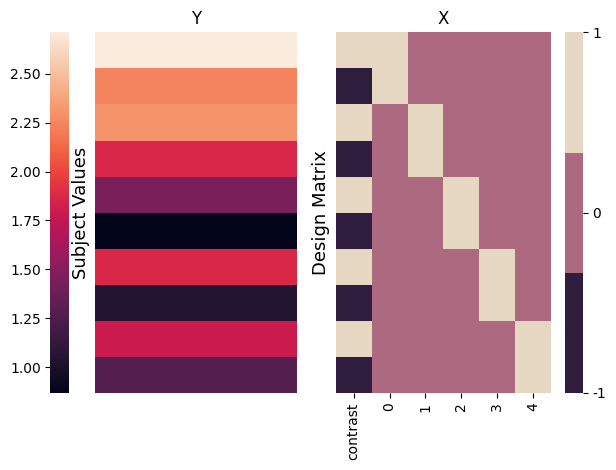

In [77]:
run_regression_simulation(X, y, paired= True)

#### Interpreting Contrast

The $n$ + 1 $\beta$’s.

$\beta_0$ = condition contrast, or the contrast $\beta$. The other $\beta$’s is each subject’s mean. We can see that the means of all subject $\beta$’s corresponds to the mean of $y$.

So... how to interpret the contrast $beta$?

We demonstrate it is not the average within subject betweencondition difference, which is different than a normal paired-samples t-test.

Rather, the contrast reflects the average deviation of a condition from the mean of each subject.

$\Sigma_{i=1}^n \frac{a+i-\mu(y_i)}{n}$

where $n$ is the number of subjects, $a$ is the condition being compared to $b$, and the $\mu(y_i)$ is the subject’s mean.


#### Regression table of results

Here is a regression table output of the same analysis.

In [78]:

import statsmodels.api as sm
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     49.18
Date:                Thu, 30 Nov 2023   Prob (F-statistic):            0.00110
Time:                        17:03:32   Log-Likelihood:                 12.326
No. Observations:                  10   AIC:                            -12.65
Df Residuals:                       4   BIC:                            -10.84
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
contrast       0.2833      0.035      8.032      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Group Comparisions Contrasts

Now we will simulate group data to demonstrate the following group based contrasts.

In [79]:
#BOLD
group1 = []
group2 = []
for i in range(20):
  group1.append(sim_fo_ts(amplitude=np.abs(np.random.randn())*3, sigma=0.20)[5])
  group2.append(sim_fo_ts(amplitude=np.abs(np.random.randn()), sigma=0.15)[5])

In [80]:
# GLM individual-Level estimation
intercept = np.ones(n_tr)
X = np.vstack([intercept, face, obj]).T

# Level 1
betas_g1 = []
p_val_g1 = []
r_squ_g1 = []
mse_res_g1 = []

betas_g2 = []
p_val_g2 = []
r_squ_g2 = []
mse_res_g2 = []

for i in range(len(group1)):
  betas_g1.append(sm.OLS(group1[i], X).fit().params)
  p_val_g1.append(sm.OLS(group1[i], X).fit().pvalues)
  r_squ_g1.append(sm.OLS(group1[i], X).fit().rsquared)
  mse_res_g1.append(sm.OLS(group1[i], X).fit().mse_resid)
  betas_g2.append(sm.OLS(group2[i], X).fit().params)
  p_val_g2.append(sm.OLS(group2[i], X).fit().pvalues)
  r_squ_g2.append(sm.OLS(group2[i], X).fit().rsquared)
  mse_res_g2.append(sm.OLS(group2[i], X).fit().mse_resid)


In [81]:
# Separating groups
group1 = []
group2 = []
for i in range(len(betas_g1)):
  group1.append(betas_g1[i][1])
  group1.append(betas_g1[i][2])
  group2.append(betas_g2[i][1])
  group2.append(betas_g2[i][2])

### Independent-Samples T-Test - Dummy Codes

Next, let’s explore how we can compute an independent-sample t-test using a regression. There are several different ways to compute this. Each of them provides a different way to test for differences between the means of the two samples.

First, we will explore how dummy codes can be used to test for group differences. We will create a design matrix with an intercept and also a column with a binary regressor indicating group membership. The target group will be ones, and the reference group will be zeros.

[s1] = [1 1]

[s2] = [1 1]

[s3] = [1 1]

Let’s run another simulation examining what the regression coefficients reflect using this dummy code approach.

betas: [1.18133049 1.97368896]
2nd-level
    Intercept:
        beta0:  1.1813304860141236
        sig   1.5944231115394558e-06
    Estimate:
        beta1:  1.9736889620908133
        sig:   3.270293813528724e-08
    beta0 + beta1: 3.155019448104937
    beta0 - beta1: -0.7923584760766897
1st level
    mean(group1): 3.1550194481049383
    mean(group2): 1.1813304860141234
    mean(group1) - mean(group2): 1.973688962090815
    mean(y): 2.1681749670595307


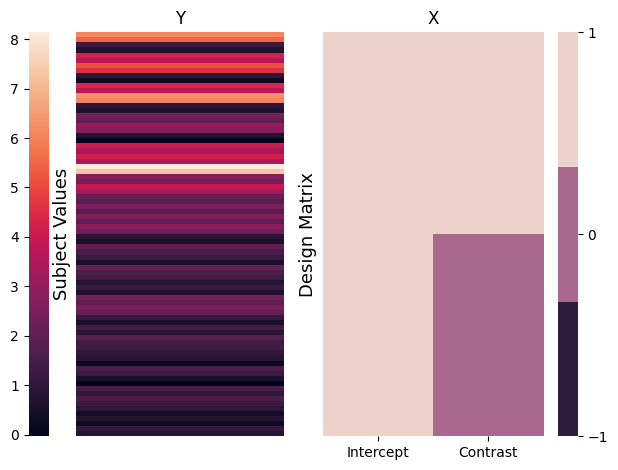

In [82]:
y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)),
                  'Contrast':np.hstack([np.ones(int(len(group1))),
                                        np.zeros(int(len(group2)))])})

run_regression_simulation(x=x, y=y)

#### What are the beta estimates representing?

- The intercept $\beta_0$ = the mean of the reference group
  - compare $\beta_0$ to mean(group2) in 1st level output
- The estimate $\beta_1$ = the difference of the mean of the target group from the reference group
  - compare $\beta_1$ to mean(group1) - mean(group2) in 1st level
- $\beta_0 + \beta_1$ = the mean of the target group
  - compare beta0 + beta1 in 2nd level to mean(group1) in 1st level output

Here is the same example with a traditional regression output

In [83]:
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     37.66
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           3.27e-08
Time:                        17:04:23   Log-Likelihood:                -141.58
No. Observations:                  80   AIC:                             287.2
Df Residuals:                      78   BIC:                             291.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1813      0.227      5.195      0.0

#### Comparing faces condition between groups
Now instead of just comparing group 1 from group 2 across the entire task
lets compare estimates during faces independent from object

betas: [2.03464181 0.26706631]
2nd-level
    Intercept:
        beta0:  2.034641810366291
        sig   1.54960044795871e-10
    Estimate:
        beta1:  0.26706631338647824
        sig:   0.49601056101357743
    beta0 + beta1: 2.3017081237527695
    beta0 - beta1: 1.7675754969798128
1st level
    mean(group1): 2.3017081237527703
    mean(group2): 2.034641810366291
    mean(group1) - mean(group2): 0.26706631338647924
    mean(y): 2.1681749670595307


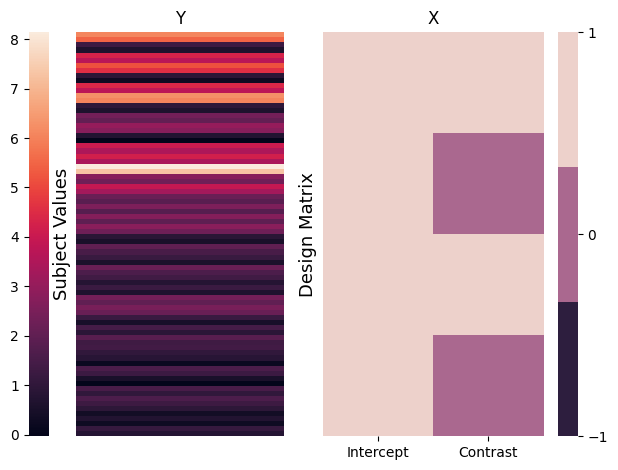

In [84]:
y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)),
                  'Contrast':np.hstack([np.ones(int(len(group1)/2)),
                                        np.zeros(int(len(group2)/2)),
                                        np.ones(int(len(group1)/2)),
                                        np.zeros(int(len(group2)/2))])})

run_regression_simulation(x, y)

#### What are the beta estimates here?

- The intercept $\beta_0$ = the mean of $Face$ for the reference group
  - compare $\beta_0$ to mean(group2) in 1st level output
- The estimate $\beta_1$ = the difference of the mean of the target group $Face$ activation from the reference group $Face$ activation.
  - compare $\beta_1$ to mean(group1) - mean(group2) in 1st level
    - In this case are $Face$ activation values by group
- $\beta_0 + \beta_1$ = the mean of the target group $Face$ activation
  - compare beta0 + beta1 in 2nd level to mean(group1) in 1st level output


### Independent-Samples T-Test - Contrasts
Another way to compare two different groups is by creating a model with an intercept and contrast between the two groups.

betas: [2.16817497 0.98684448]
2nd-level
    Intercept:
        beta0:  2.1681749670595307
        sig   0.0
    Estimate:
        beta1:  0.9868444810454071
        sig:   3.270293813528724e-08
    beta0 + beta1: 3.155019448104938
    beta0 - beta1: 1.1813304860141236
1st level
    mean(group1): 3.1550194481049383
    mean(group2): 1.1813304860141234
    mean(group1) - mean(group2): 1.973688962090815
    mean(y): 2.1681749670595307


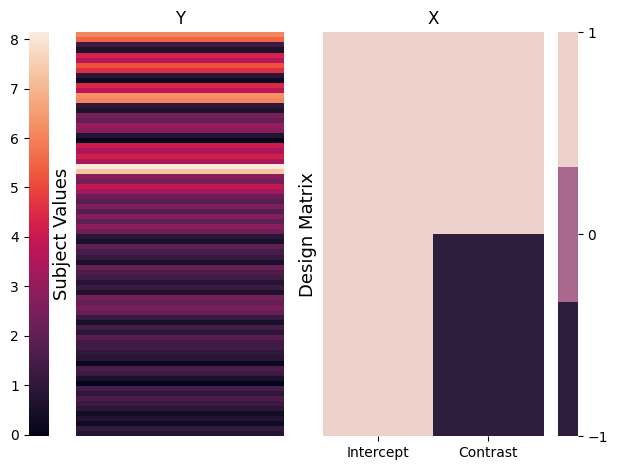

In [86]:
y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)),
                  'Contrast':np.hstack([np.ones(int(len(group1))),
                                        -1*np.ones(int(len(group2)))])})

run_regression_simulation(x, y)

#### What are the estimates now?

- intercept $\beta_0$ = the mean of $y$
-  $\beta_1$ = the average distance of each group to the mean.
- $\beta_0 + \beta_1$ = the mean of group 1
-  $\beta_0 - \beta_1$ = the mean of group 2


Lets contrast activtion during the face condition between groups.

betas: [1.68538663 0.10312028]
2nd-level
    Intercept:
        beta0:  1.6853866269859539
        sig   0.0
    Estimate:
        beta1:  0.10312027628564327
        sig:   0.5043257496768123
    beta0 + beta1: 1.7885069032715972
    beta0 - beta1: 1.5822663507003105
1st level
    mean(group1): 1.7885069032715983
    mean(group2): 1.5822663507003107
    mean(group1) - mean(group2): 0.2062405525712876
    mean(y): 1.6853866269859545


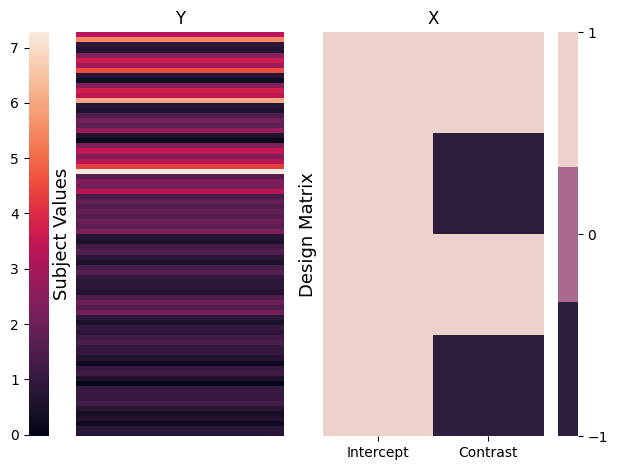

In [ ]:
y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)),
                  'Contrast':np.hstack([np.ones(int(len(group1)/2)),
                                        -1*np.ones(int(len(group2)/2)),
                                        np.ones(int(len(group1)/2)),
                                        -1*np.ones(int(len(group2)/2))])})

run_regression_simulation(x, y)

#### In this contrast

- intercept $\beta_0$ = the mean of $y$
-  $\beta_1$ = the average distance of $Face$ activation for each group from the mean.

- $\beta_0 + \beta_1$ = The mean of $Face$ activation for group 1
- $\beta_0 - \beta_1$ = The mean of $Face$ activation for group 2

## Independent-Samples T-Test - Group Intercepts
The third way to calculate an independent samples t-test using a regression is to split the intercept into two separate binary regressors with each reflecting the membership of each group. There is no need to include an intercept as it is simply a linear combination of the other two regressors.

[s1] = [1 0]

[s2] = [1 0]

[s3] = [0 1]

[s3] = [0 1]



betas: [3.15501945 1.18133049]
2nd-level
    Group 2:
        beta0:  3.1550194481049383
        sig   0.0
    Group 1:
        beta1:  1.1813304860141234
        sig:   1.5944231115394558e-06
    beta0 + beta1: 4.3363499341190614
    beta0 - beta1: 1.973688962090815
1st level
    mean(group1): 1.1813304860141234
    mean(group2): 3.1550194481049383
    mean(group1) - mean(group2): -1.973688962090815
    mean(y): 2.1681749670595307


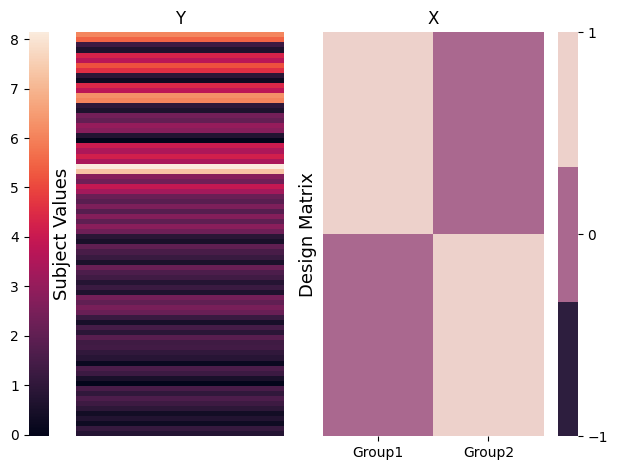

In [87]:

y = np.hstack([group1, group2])
x = pd.DataFrame({'Group1':np.hstack([np.ones(len(group1)), np.zeros(len(group2))]),
                  'Group2':np.hstack([np.zeros(len(group1)), np.ones(len(group2))])})

run_regression_simulation(x, y, gint= True)

#### Estimates
This is obviously just estimating the mean for each group (not a between group test) - if we want to estimate the magnitude of difference we would need a contraxt of [1,-1].

### Adding contrasts

Here we add a group contrast accounting for group level means

betas: [0.65789632 2.49712313 1.83922681]
2nd-level
    Contrast beta:
        beta0:  0.6578963206969384
          sig   4.006765985664629e-08
    Mean Group 1:
        beta1:  2.4971231274079995
         sig:   0.0
    Mean Group 2:
        beta2:  1.8392268067110606
         sig:   0.0
    beta0 + beta1: 3.155019448104938
    abs(beta0 - beta2): 1.1813304860141223
    beta0 + mean(y): 2.826071287756469
    abs(beta0 - mean(y)): 1.5102786463625923
    beta1 + beta2: 4.33634993411906
1st level
    mean(group1): 3.1550194481049383
    mean(group2): 1.1813304860141234
    mean(group1) + mean(group2): 4.3363499341190614
    mean(group1) - mean(group2): 1.973688962090815
    mean(group1) - mean(group2) / 2: 0.9868444810454075
    mean(y): 2.1681749670595307


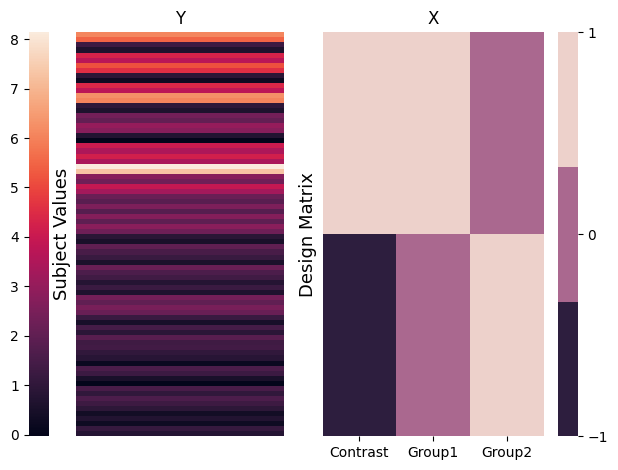

In [88]:
y = np.hstack([group1, group2])
x = pd.DataFrame({#'intercept':np.hstack([np.ones(len(y))]),
                  'Contrast':np.hstack([np.ones(int(len(group1))),
                                        -1*np.ones(int(len(group2)))]),
                  'Group1':np.hstack([np.ones(len(group1)), np.zeros(len(group1))]),
                  'Group2':np.hstack([np.zeros(len(group1)), np.ones(len(group2))])})

run_regression_simulation(x, y, gint_c=True)

The betas here

$\beta_0$ = contrast between groups after accounting for group-level means
* (1) At level 2 this involves the betas
  - $\beta_0$ = $\beta_1$ - $\beta_2$
* (2) At level 1 this involves parsing group differences by the three parameters in the model
  - (mean(group1) - mean(group2)) / 3

$\beta_1$ and $\beta_2$ take on values representing a group specific separation of available variance in the model given the contrast:

* (1) At level 2: the overall variance available in the model after accounting for the contrast.
  - $\beta_1$ + $\beta_2$ = mean(group1) + mean(group2)
  - $\beta_1$ = the mean for group one after accounting for the contrast
    - (mean(group1) - $\beta_0$) OR ($\beta_0$ + $\beta_1$)
  - $\beta_2$ = the mean for group two after accounting for the contrast
    - (mean(group2) + $\beta_0$) OR ($\beta_0$ - $\beta_2$)

* (2) at level 1: have the contrast respective to the mean of y.
  - $\beta_1$ = mean(y) + $\frac{\beta_0}{2}$ OR $\beta_1$ = mean(y) + $\frac{mean(group1) - mean(group2)}{3}$
  - $\beta_2$ = mean(y) - $\frac{\beta_0}{2}$ OR $\beta_2$ = mean(y) - $\frac{mean(group1) - mean(group2)}{3}$



Here we do the same as above only focusing on faces > objects contrast accounting for overall group mean

betas: [0.13353316 3.15501945 1.18133049]
2nd-level
    Contrast beta:
        beta0:  0.13353315669323976
          sig   0.40980465891262385
    Mean Group 1:
        beta1:  3.155019448104938
         sig:   0.0
    Mean Group 2:
        beta2:  1.1813304860141232
         sig:   1.6987580206961894e-06
    beta0 + beta1: 3.2885526047981775
    abs(beta0 - beta2): 1.0477973293208833
    beta0 + mean(y): 2.3017081237527703
    abs(beta0 - mean(y)): 2.034641810366291
    beta1 + beta2: 4.3363499341190614
1st level
    mean(group1): 2.3017081237527703
    mean(group2): 2.034641810366291
    mean(group1) + mean(group2): 4.3363499341190614
    mean(group1) - mean(group2): 0.26706631338647924
    mean(group1) - mean(group2) / 2: 0.13353315669323962
    mean(y): 2.1681749670595307


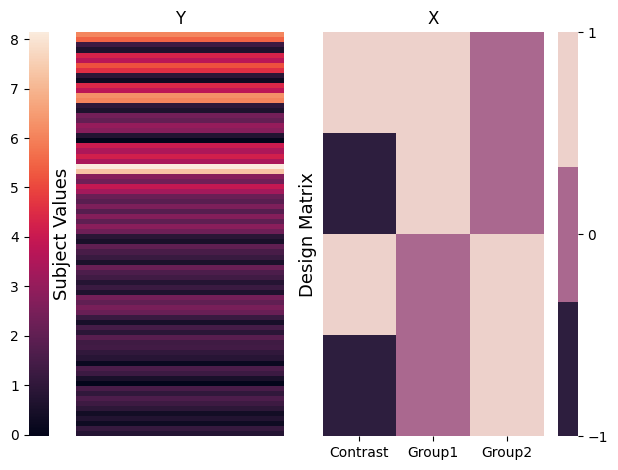

In [93]:
y = np.hstack([group1, group2])
x = pd.DataFrame({'Contrast':np.hstack([np.ones(int(len(group1)/2)),
                                      -1*np.ones(int(len(group2)/2)),
                                      np.ones(int(len(group1)/2)),
                                      -1*np.ones(int(len(group2)/2))]),
                  'Group1':np.hstack([np.ones(len(group1)), np.zeros(len(group1))]),
                  'Group2':np.hstack([np.zeros(len(group1)), np.ones(len(group2))])})

run_regression_simulation(x, y, gint_c=True)

## Summary

Here we have simulated multipe participants and conducted a series of contrasts between conditions.

Next we will conduct a whole brain analysis comparision contrasting between conditions and maping these results on a figure of the brain.

